![Baseball Flights](baseball_flights.png)


To the Office of Transportation at The 22nd Century Sporting League,

After our inaugural 2101 season, The League is looking for ways to optimize our game scheduling process and costs.  We know that transportation logistics are a major variable to consider during scheduling, and as such, we’ve got a few questions for you. 

Our primary areas of focus are surrounding the number of jets that The League needs to own, and the cost of fuel for those flights. If we want The League to enjoy continued success, we'll need to make sure we manage transportation costs.

We’re sharing schedule data for the upcoming 2102 season.  On each row, you’ll find information about which teams are needing to travel to their next set of games, the time the flight will likely depart (based on our estimations of gameplay durations) and the time the flight will likely land. 

Additionally, we're also providing the fuel price that was paid each day during this past 2101 season. The fuel price fluctuates over time, but we're hoping you'll be able to project it to the future to help with the analysis.

## The Data

### team_flights.csv

| Column     | Description              |
|------------|--------------------------|
| `team_name` | Official team name |
| `departure_datetime` | Date and Time (in UTC) when the flight will depart |
| `landing_datetime` | Date and Time (in UTC) when the flight will land |


### fuel_price.csv

| Column     | Description              |
|------------|--------------------------|
| `date` | Date when the fuel price was recorded |
| `fuel_price` | Corresponding fuel price (in $ per gallon) |


### Important Things to Know
- You can assume that the flight's average speed is 500 MPH. (So, as an example, a 2-hour flight would travel 1000 miles)
- You can assume that each team’s jet fills up with fuel equivalent to 1 gallon per mile-of-travel 
- You can assume that the jet is fueled on the day the travel departs (and thus can use the fuel price corresponding to the departure date)

In [31]:
# Import required modules
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

pd.set_option('display.width', 1000)

In [32]:
# Explore the data
team_flights = pd.read_csv('./team_flights.csv')
fuel_prices = pd.read_csv('./fuel_prices_2101.csv',index_col='date')

In [33]:
print(team_flights.head())

         team_name   departure_datetime     landing_datetime  travel_distance_miles
0  Agile Antelopes  2102-04-06 21:37:00  2102-04-07 00:35:57            1491.250000
1  Agile Antelopes  2102-04-10 23:57:00  2102-04-11 01:35:40             822.222222
2  Agile Antelopes  2102-04-14 00:29:00  2102-04-14 05:02:55            2282.638889
3  Agile Antelopes  2102-04-21 03:31:00  2102-04-21 05:23:09             934.583333
4  Agile Antelopes  2102-04-24 22:23:00  2102-04-25 00:25:50            1023.611111


In [34]:
print(fuel_prices.head())

            price
date             
2101-01-01   0.97
2101-01-02   0.87
2101-01-03   0.87
2101-01-04   0.97
2101-01-05   1.10


In [35]:
# Some basic data cleaning and pre-processing
team_flights['departure_datetime'] = pd.to_datetime(team_flights['departure_datetime'])
team_flights['landing_datetime']   = pd.to_datetime(team_flights['landing_datetime'])

fuel_prices.index = pd.DatetimeIndex(fuel_prices.index).to_period('D')

Answer the following questions to help The League optimize their flight schedules, keeping the **important things to know** in mind.

- We're interested in the maximum number of jets that The League needs to own. Create a time-series graph that shows how many teams will be “in flight” throughout the 2102 season. Use this graphic to tell us the maximum number of teams simultaneously in flight. Store these results in variables named `max_teams_in_flight`.

In [36]:
datetimes = pd.concat([team_flights['departure_datetime'], team_flights['landing_datetime']])

datetimes_sorted = sorted(list(datetimes))
datetimes_sorted.append(pd.to_datetime('2102-04-01 00:00:00'))
datetimes_sorted.append(pd.to_datetime('2102-10-05 00:00:00'))

flight_df = pd.DataFrame({'date':sorted(datetimes_sorted),'in_flight':0})

for i, flight in team_flights.iterrows():
    flight_df.loc[(flight_df['date'] >= flight['departure_datetime']) & (flight_df['date'] < flight['landing_datetime']), 'in_flight'] += 1
    
print(flight_df.head())

                 date  in_flight
0 2102-04-01 00:00:00          0
1 2102-04-03 21:40:00          2
2 2102-04-03 21:40:00          2
3 2102-04-03 21:52:00          3
4 2102-04-03 22:02:00          4


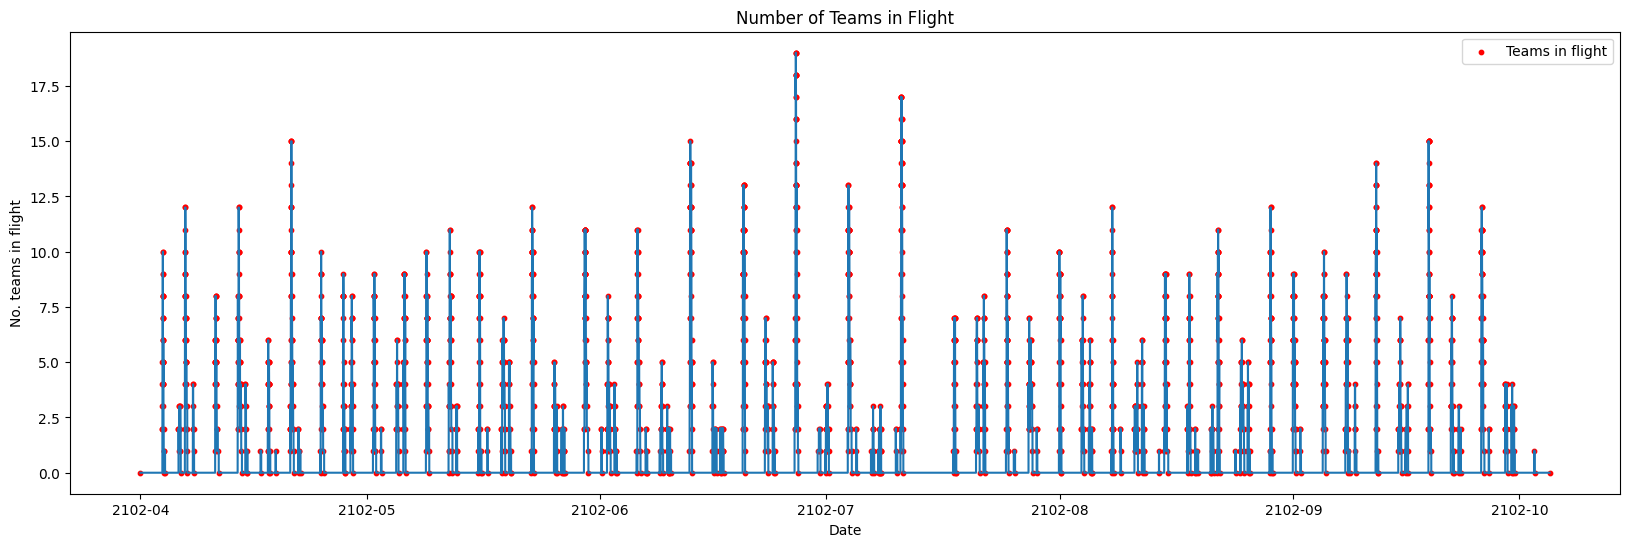

In [37]:
# Plot
fig, ax = plt.subplots(figsize=(20, 6))

ax.step(flight_df['date'], flight_df['in_flight'], where='post') 
ax.scatter(flight_df['date'], flight_df['in_flight'], color='red', s=10, marker='o', label='Teams in flight')
ax.legend(loc='upper right')
ax.set_xlabel('Date') 
ax.set_ylabel('No. teams in flight') 
ax.set_title('Number of Teams in Flight') 
plt.show()

In [38]:
max_teams_in_flight = flight_df['in_flight'].max()
print(f'Maximum number of teams in flight: {max_teams_in_flight}')

Maximum number of teams in flight: 19


- Use 2101's jet fuel prices to project jet fuel prices for 2102. Apply these projections to every flight taken by every team to determine the overall fuel spend for 2102. Store your result in a variable named `total_fuel_spend_2102_dollars`.

In [39]:
sarimax_model = SARIMAX(fuel_prices, order=(1, 1, 1), seasonal_order=(1, 0, 0, 7))  
model  =  sarimax_model.fit()

forecast = model.get_forecast(steps=365)    # 365 days in 2102

In [40]:
fuel_prices_forecast = pd.DataFrame(data={"date": forecast.summary_frame().index.to_timestamp(), 
                                        "price":forecast.predicted_mean.values})

print(fuel_prices_forecast.head())

        date     price
0 2102-01-01  1.227113
1 2102-01-02  1.237164
2 2102-01-03  1.336952
3 2102-01-04  1.466675
4 2102-01-05  1.516568


In [41]:
team_flights['departure_date'] = team_flights['departure_datetime'].dt.date

fuel_prices_forecast['date'] = fuel_prices_forecast['date'].dt.date
fuel_prices_forecast.set_index('date', inplace=True)
merged_df = team_flights.join(fuel_prices_forecast, on='departure_date', how='left')
merged_df['fuel_cost_total'] = merged_df['price'] * merged_df['travel_distance_miles'] 
print(merged_df.head())

         team_name  departure_datetime    landing_datetime  travel_distance_miles departure_date     price  fuel_cost_total
0  Agile Antelopes 2102-04-06 21:37:00 2102-04-07 00:35:57            1491.250000     2102-04-06  1.600689      2387.026985
1  Agile Antelopes 2102-04-10 23:57:00 2102-04-11 01:35:40             822.222222     2102-04-10  1.335888      1098.396444
2  Agile Antelopes 2102-04-14 00:29:00 2102-04-14 05:02:55            2282.638889     2102-04-14  1.558639      3557.810447
3  Agile Antelopes 2102-04-21 03:31:00 2102-04-21 05:23:09             934.583333     2102-04-21  1.565104      1462.719650
4  Agile Antelopes 2102-04-24 22:23:00 2102-04-25 00:25:50            1023.611111     2102-04-24  1.349752      1381.620658


In [44]:
total_fuel_spend_2102_dollars = merged_df['fuel_cost_total'].sum()
print(f'Total fuel spend in 2102: ${total_fuel_spend_2102_dollars}')

Total fuel spend in 2102: $1859747.9221818678
